# Softmax
Softmax Classifier
- implement a **fully-vectorized loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- check your implementation with numerical gradient
- use a validation set to **tune the learning rate and regularization strength**
- **optimize** the loss function with **SGD**
- visualize the final learned weights 

Platform:
Win10 64bit
python3.5

## Basic settings

In [1]:
# Import the esential libs
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

In [2]:
# set the matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# optional setting
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

## Cifar-10 Data loading and preprocessing

In [3]:
# Load the raw CIFAR-10 data.
X_tr, y_tr, X_te, y_te = load_CIFAR10('D:/CS231N_CNN/DataSet/cifar-10-batches-py/')
# As a sanity check, we print out the size of the traning ans test data
print('Training data shape:   ', X_tr.shape)
print('Training labels shape: ', y_tr.shape)
print('Test data shape:       ', X_te.shape)
print('Test labels shape:     ', y_te.shape) 

D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_1
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_2
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_3
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_4
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_5
Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


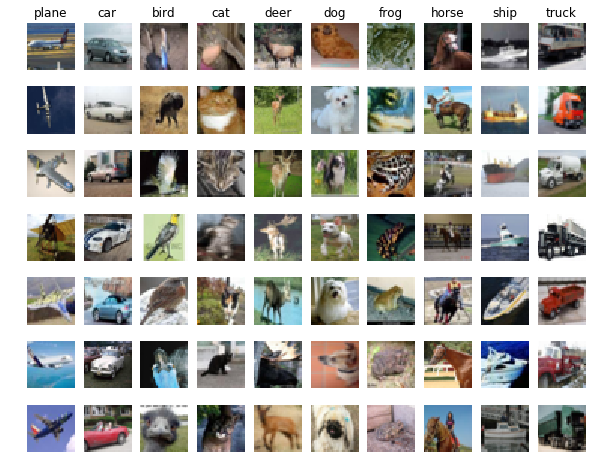

In [4]:
# visualize some examples from the dataset
# We show a few examples of trainging images from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_tr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_tr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)


plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000

# Validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_tr[mask]
y_val = y_tr[mask]

# Training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_tr[mask]
y_train = y_tr[mask]

# Use the first num_test points of the original test set as the test set.
mask = range(num_test)
X_test = X_te[mask]
y_test = y_te[mask]

print('Train data shape:        ', X_train.shape) 
print('Train labels shape:      ', y_train.shape) 
print('Validation data shape:   ', X_val.shape) 
print('Validation labels shape: ', y_val.shape) 
print('Test data shape:         ', X_test.shape) 
print('Test labels shape:       ', y_test.shape) 

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape) 
print('Validation data shape: ', X_val.shape) 
print('Test data shape:       ', X_test.shape) 

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000,)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000,)
Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


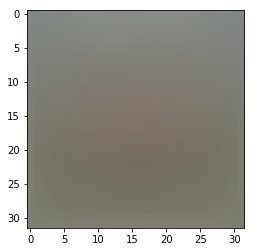

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis = 0)
print(mean_image[:10]) # print a few of the elements

plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [7]:
# second: substract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print(X_train.shape, X_val.shape, X_test.shape)

(3073, 49000) (3073, 1000) (3073, 1000)


In [8]:
del X_tr

## Softmax Classifier

Firstly, we will evaluate the naive implementation of the loss. 

In the Softmax classifier, the function mapping $f\left( {{x_i};W} \right) = W{x_i}$ stays unchanged, but we now interpret these scores as the **unnormalized log probabilities** for each class and replace the hinge loss with a **cross-entropy loss** that has the form:

$$
L{_i} =  - \log \left( {\frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_j {{e^{{f_j}}}} }}} \right) =  - {f_{{y_i}}} + \log \left( {\sum\nolimits_j {{e^{{f_j}}}} } \right)
$$

where we are using the notation $f_j$ to mean the j-th element of the vector of class scores $f$. As before, the full loss for the dataset is the mean of $L_i$ over all training examples together with a regularization term $R(W)$. The function ${f_j}\left( z \right) = \frac{{{e^{{z_j}}}}}{{\sum\nolimits_k {{e^{{z_k}}}} }}$is called the **softmax function**: It takes a vector of arbitrary real-valued scores (in $z$) and squashes it to a vector of values between zero and one that sum to one. 

**Probabilistic interpretation** 

Looking at the expression, we see that

$$
P\left( {{y_i}\left| {{x_i};W} \right.} \right) = \frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_j {{e^{{f_j}}}} }}
$$

can be interpreted as the **(normalized) probability** assigned to the correct label $y_i$ given the image $x_i$ and parameterized by $W$ . To see this, remember that the Softmax classifier interprets the scores inside the output vector $f$ as the **unnormalized log probabilities**. Exponentiating these quantities therefore gives the (unnormalized) probabilities, and the division performs the normalization so that the probabilities sum to one. In the probabilistic interpretation, we are therefore **minimizing the negative log likelihood of the correct class**, which can be interpreted as performing **Maximum Likelihood Estimation (MLE)**. A nice feature of this view is that we can now also interpret the regularization term $R(W)$ in the full loss function as coming from a **Gaussian prior** over the weight matrix $W$, where instead of MLE we are performing the **Maximum a posteriori (MAP) estimation**. We mention these interpretations to help your intuitions, but the full details of this derivation are beyond the scope of this class.

<font color=#FF0000 >**Code Instruction**</font>

**Practical issues** 

${{e^{{f_{{y_i}}}}}}$ and ${\sum\nolimits_j {{e^{{f_j}}}} }$ may be very large due to the exponentials. Dividing large numbers can be numerically unstable, so it is important to use a **normalization trick**. Notice that if we multiply the top and bottom of the fraction by a constant $C$ and push it into the sum, we get the following (mathematically equivalent) expression:

$$
\frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_j {{e^{{f_j}}}} }} = \frac{{C \cdot {e^{{f_{{y_i}}}}}}}{{C \cdot \sum\nolimits_j {{e^{{f_j}}}} }} = \frac{{{e^{{f_{{y_i}}} + \log C}}}}{{\sum\nolimits_j {{e^{{f_j} + \log C}}} }}
$$

We are free to choose the value of $C$. This will not change any of the results, but we can use this value to improve the numerical stability of the computation. A common choice for $C$ is to set $\log C =  - {\max _j}{f_j}$. In code:

(1) **Loss**

```python
for i in range(num_train):
        scores = W.dot(X[:, i])
        scores -= np.max(scores) # correct for numerical stability

        # Loss = -f_yi + log(sum(e^(f_j)))
        loss -= scores[y[i]]

        sum_exp = 0.0
        for s in scores:
            sum_exp += np.exp(s)

        # Here: calculate gradient w.r.t W
            
        loss += np.log(sum_exp)
```

(2) **Gradient**

$$
L{ _i} =  - \log \left( {\frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_k {{e^{{f_k}}}} }}} \right)
$$

when $j \ne {y_i}$

$$
\frac{{\partial {L_i}}}{{\partial {f_j}}} = \frac{1}{{\frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_k {{e^{{f_k}}}} }}}}\frac{{{e^{{f_{{y_i}}}}}}}{{{{\left( {\sum\nolimits_k {{e^{{f_k}}}} } \right)}^2}}}{e^{{f_j}}} = \frac{{{e^{{f_j}}}}}{{\sum\nolimits_j {{e^{{f_k}}}} }}
$$

when $j = {y_i}$

$$
\begin{align}
\frac{{\partial {L_i}}}{{\partial {f_{{y_i}}}}} &=  - \frac{1}{{\frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_j {{e^{{f_j}}}} }}}} \cdot \frac{{{e^{{f_{{y_i}}}}} \cdot \sum\nolimits_j {{e^{{f_j}}}}  - {e^{{f_{{y_i}}}}} \cdot {e^{{f_{{y_i}}}}}}}{{{{\left( {\sum\nolimits_j {{e^{{f_j}}}} } \right)}^2}}}\\
 &= \frac{{{e^{{f_{{y_i}}}}}}}{{\sum\nolimits_j {{e^{{f_j}}}} }} - 1
\end{align}
$$

In [9]:
from cs231n.gradient_check import grad_check_sparse
from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_vectorized

# generate a random weight matrix of small numbers
W = np.random.randn(num_classes, X_train.shape[0]) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)
print('softmax loss naive is %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

softmax loss naive is 2.383867
sanity check: 2.302585


In [10]:
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.

f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.186388 analytic: 2.186388, relative error: 3.029023e-08
numerical: -5.937694 analytic: -5.937694, relative error: 3.446093e-09
numerical: 1.892018 analytic: 1.892018, relative error: 2.263402e-08
numerical: -0.907202 analytic: -0.907202, relative error: 1.505685e-08
numerical: 2.428047 analytic: 2.428047, relative error: 4.373096e-08
numerical: -1.551905 analytic: -1.551905, relative error: 5.025689e-09
numerical: 0.547784 analytic: 0.547784, relative error: 1.697926e-08
numerical: 1.208605 analytic: 1.208605, relative error: 7.595214e-08
numerical: -1.373008 analytic: -1.373008, relative error: 3.240961e-08
numerical: 0.779533 analytic: 0.779533, relative error: 2.828240e-08


<font color=#FF0000 >**Code Instruction**</font>

**A vectorized version of gradient calculation**

(1) **Loss**

```python
scores = np.dot(W, X)
scores -= np.max(scores)        # K x N

exp_scores = np.exp(scores)
sums_exp = np.sum(exp_scores, axis = 0)
result = np.log(sums_exp) - scores[y, np.arange(0, scores.shape[1])]

loss = np.sum(result)
```
(2) **Gradient**
```python
y_mat = np.zeros(shape = (K, N))
y_mat[y, range(N)] = 1

sums_exp_scores = np.sum(exp_scores, axis=0)
sums_exp_scores = 1.0 / (sums_exp_scores + 1e-8)  # 1 x N

df = exp_scores * sums_exp_scores                 # K x N
 
dW = np.dot(df, X.T)                              # derivative chain rule
dW -= np.dot(y_mat, X.T)
```

In [11]:
import time
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.383867e+00 computed in 4.265842s
vectorized loss: 2.383867e+00 computed in 0.407585s
Loss difference: 0.000000
Gradient difference: 0.000001


## Stochastic Gradient Descent

iteration 0 / 1500: loss 769.596218
iteration 100 / 1500: loss 282.403003
iteration 200 / 1500: loss 104.727846
iteration 300 / 1500: loss 39.569862
iteration 400 / 1500: loss 15.793844
iteration 500 / 1500: loss 7.119121
iteration 600 / 1500: loss 3.896989
iteration 700 / 1500: loss 2.721009
iteration 800 / 1500: loss 2.292163
iteration 900 / 1500: loss 2.135567
iteration 1000 / 1500: loss 2.143010
iteration 1100 / 1500: loss 2.091394
iteration 1200 / 1500: loss 2.079915
iteration 1300 / 1500: loss 2.103407
iteration 1400 / 1500: loss 2.072959
That took 5.326798s


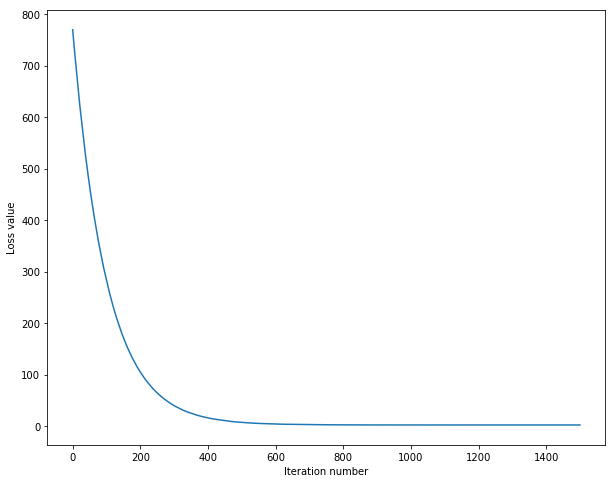

In [12]:
from cs231n.classifiers.linear_classifier import Softmax, LinearClassifier
# Now implement SGD in Softmax.train() function and run it with the code below
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate = 1e-7, reg = 5e4, num_iters=1500, verbose=True)
toc = time.time()

print('That took %fs' % (toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

evaluate the performance on both training and validation set using the predict() function

In [13]:
# evaluate the performance on both
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy:%f' % (np.mean(y_train == y_train_pred)))
y_val_pred = softmax.predict(X_val)
print('validation accuracy:%f' % (np.mean(y_val == y_val_pred)))

training accuracy:0.328694
validation accuracy:0.343000


### Validation
**use the validation set to tune hyperparameter (regularization strength and learning rate)**. You should experiment with different ranges for the learning rates and regularization strengths

In [14]:
# choices for the regularization strength and learning_rate
learning_rates = [1e-7, 2e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 2e4, 5e4, 1e5, 5e5, 1e6]

In [15]:
# results are dictionary mapping tuples of the form 
# (learning_rate, regularization_strength) to tuples of the form 
# (training_accuracy, validation_accuracy). The accuracy is simply the fration 
# of data points that are correctly classified.

results = {}
best_val = -1    # The highest validation accuracy that we have seen so far.
best_softmax = None  # The LinearSVM object that chieved the highest validation rate.

for learning in learning_rates:
    for regularition in regularization_strengths:

        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=learning, reg = regularition, num_iters=2000)

        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)

        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
            print('best val is %f' % best_val)

        results[(learning, regularition)] = (training_accuracy, validation_accuracy)
        print('learning rate %e,regularization %e. train accuracy:%f val accuracy: %f' % (learning, regularition, training_accuracy, validation_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

best val is 0.381000
learning rate 1.000000e-07,regularization 1.000000e+04. train accuracy:0.355490 val accuracy: 0.381000
learning rate 1.000000e-07,regularization 2.000000e+04. train accuracy:0.358020 val accuracy: 0.369000
learning rate 1.000000e-07,regularization 5.000000e+04. train accuracy:0.327020 val accuracy: 0.347000
learning rate 1.000000e-07,regularization 1.000000e+05. train accuracy:0.310612 val accuracy: 0.324000
learning rate 1.000000e-07,regularization 5.000000e+05. train accuracy:0.275612 val accuracy: 0.293000
learning rate 1.000000e-07,regularization 1.000000e+06. train accuracy:0.259776 val accuracy: 0.253000
best val is 0.387000
learning rate 2.000000e-07,regularization 1.000000e+04. train accuracy:0.373776 val accuracy: 0.387000
learning rate 2.000000e-07,regularization 2.000000e+04. train accuracy:0.356551 val accuracy: 0.369000
learning rate 2.000000e-07,regularization 5.000000e+04. train accuracy:0.322306 val accuracy: 0.326000
learning rate 2.000000e-07,regu

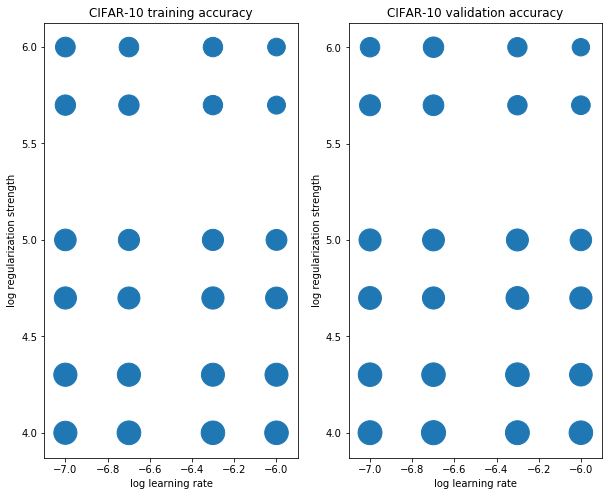

In [16]:
import math
# Visualize the cross-validation results
    
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results]
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results]
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax on raw pixels final test set accuracy: 0.374000


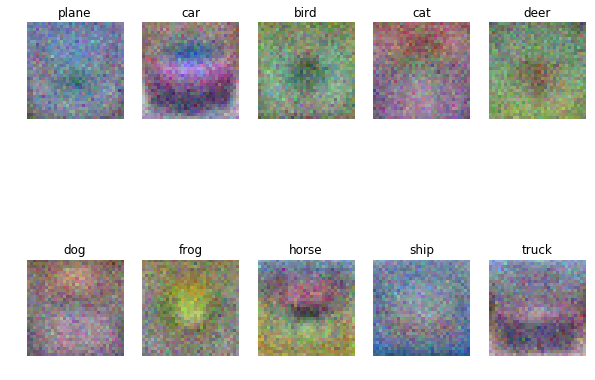

In [18]:
# Visulize the learned weights for each class.
# Depending on your choice of learning rate and regularition strength, these may 
# or may not be nice to look at.

w = best_softmax.W[:,:-1]     # strip out the bias
w = w.reshape(10,32,32,3)
w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i+1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.show()